In [42]:
import matplotlib
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amsmath}')
import matplotlib.pyplot as plt

import numpy as np
from numpy.random import normal, randint
from scipy.stats import norm
from scipy.optimize import minimize
from scipy.stats import entropy
import sys

# KL Divergence check for Convexity

This notebook tries to demystify the convexity of the Kullback-Leibler divergence (c.f. [question](https://math.stackexchange.com/questions/3538433/convexity-of-kl-divergence-d-textklp-q-theta-in-theta)).
The nomenclature can be found in the appendix.

## Empirical proof

We sample from a multi modal Gaussian $p=0.5 (\mathcal{N}(-3, 1) + \mathcal{N}(4, 0.5)) $.
The objective of this notebook is to approximate $p$ with an uni modal Gaussian $q=\mathcal{N}(\mu, \sigma) $
 by minimizing the KL divergence between these two distributions.
Furthermore, want to use the Maximum Likelihood Estimator (MLE) to estimate the parameters $(\mu, \sigma)$.
Since we chose $q$ to be in the exponential family, we can directly estimate the paremters by calculating the first and second moment
 from samples $x\sim p$ of $p$.

In [43]:
num_samples = 5000

# Define the PDFs
p_1 = lambda x: norm(loc=-3., scale=1.).pdf(x)
p_2 = lambda x: norm(loc=4., scale=.5).pdf(x)
p = lambda x: 0.5*(p_1(x) + p_2(x))
q = lambda x,m,s: norm(loc=m, scale=s).pdf(x)

# Sample x~p
x_1 = normal(loc=-3.0, scale=1.0, size=num_samples)
x_2 = normal(loc=4.0, scale=.5, size=num_samples)
mask = randint(2, size=num_samples)
x = np.concatenate((x_1[mask == 0], x_2[mask == 1]))

# Estimate the moments by MLE (i.e. just calc. the moments)
m, s = x.mean(), x.std()

# Estimate the moments by minimizing KL divergence
X = np.linspace(x.min() - 2. * x.std(), x.max() + 2. * x.std(), num=100) # define the support
def entropy_opt(ms):
    ''' Optimization for D_KL (p || q) '''
    return entropy(pk= p(X), qk= q(X, ms[0], ms[1]))
def entropy_opt_rev(ms):
    ''' Optimization for D_KL (q || p) '''
    return entropy(qk= p(X), pk= q(X, ms[0], ms[1]))

# Optimize D_KL (p || q), which is convex anyway
dkl_opt = minimize(entropy_opt, x0=[0.,1.], method='Nelder-Mead', bounds=((-10., 10.), (.2, None)))
# Optimize D_KL (q || p) and start on the left-hand-side, which then seeks the left mode of p
dkl_rev_opt_rhs = minimize(entropy_opt_rev, x0=[2.,1.], method='Nelder-Mead', bounds=((-10., 10.), (.2, None)))
# Optimize D_KL (q || p) and start on the right-hand-side, which then seeks the right mode of p
dkl_rev_opt_lhs = minimize(entropy_opt_rev, x0=[-2.,1.], method='Nelder-Mead', bounds=((-10., 10.), (.2, None)))

/usr/local/lib/python3.5/dist-packages/scipy/optimize/_minimize.py:516: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)


### Plot the estimates

We plot the true PDF $p$ and all proxies $q$ with the different optimization techniques.
It can be seen, that MLE estimates a mean seeking distribution $q_{\text{MLE}}$.
Non-suprisingly, optimizing the DKL in the direction of ${D_{\text{KL}}(p\|q)}$ results in the same 
 distribution as the MLE with $q_{D_{\text{KL}}(p\|q)}=q_{\text{MLE}}$. This is because the maximization
 of the likelihood becomes the minimization of the DKL for $n\rightarrow \infty$ ([proof](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation#Relation_to_minimizing_Kullback%E2%80%93Leibler_divergence_and_cross_entropy)).  
However, since the MLE is a convex estimator if $q$ is in the exponential family, we can also assume that 
DKL is convex because of the identity between MLE and DKL for $n\rightarrow \infty$ ([ref: KL-divergence as an objective function](https://timvieira.github.io/blog/post/2014/10/06/kl-divergence-as-an-objective-function/)).

The other directions of the DKL $D_{\text{KL}}(q\|p)$ optimize in a way, that they seek the modes of $p$.
Therefore, $D_{\text{KL}}(q\|p)$ is definetly not a convex optimization problem in $q$, since we find different
minima for different starting conditions of the gradient descent approach of minimizing the DKL.


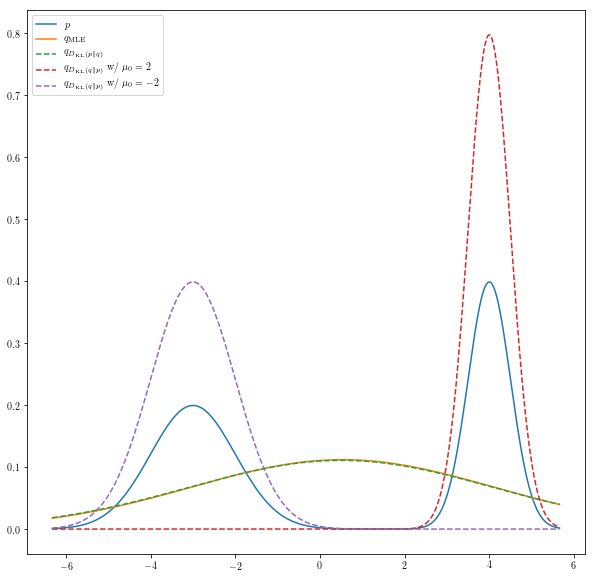

In [44]:
_, ax = plt.subplots(1,1,figsize=(10,10))
X_plt = np.linspace(x.min(), x.max(), num=300)
#ax.hist(x, bins=50, density=True)
ax.plot(X_plt, p(X_plt), label=r"$p$")
ax.plot(X_plt, q(X_plt, m, s), label=r"$q_{\text{MLE}}$")
ax.plot(X_plt, q(X_plt, dkl_opt.x[0], dkl_opt.x[1]),linestyle='dashed', label=r"$q_{D_{\text{KL}}(p\|q)}$")
ax.plot(X_plt, q(X_plt, dkl_rev_opt_rhs.x[0], dkl_rev_opt_rhs.x[1]),linestyle='dashed', label=r"$q_{D_{\text{KL}}(q\|p)}$ w/ $\mu_{0} = 2$")
ax.plot(X_plt, q(X_plt, dkl_rev_opt_lhs.x[0], dkl_rev_opt_lhs.x[1]),linestyle='dashed', label=r"$q_{D_{\text{KL}}(q\|p)}$ w/ $\mu_{0} = -2$")
plt.legend()
plt.show()



## Convexity Test

Given the definitions of convexity in the appendix, we try to test the DKL on that behaviour.

In [45]:
# Define the support
x = np.arange(-20, 20, .05)

### Defining a Set as stated in the Convexity Proof for Pairwise PDFs 

Define the functions for the [convexity proof](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence#Properties).
We can directly see that by following the proof, we define multi modal Gaussians with $\hat{q}=\theta \mathcal{N}(\mu_1 , \sigma_1 )  + (1-\theta) \mathcal{N}(\mu_2 , \sigma_2 )$.
Therefore, we cannot use this proof to show convexity of $D_{\text{KL}}(p\|q)$ or $D_{\text{KL}}(q\|p)$, when we optimizes with $q\in\mathcal{S}$ 
 with $\mathcal{S}:=\left\{ \mathcal{N}(\mu, \sigma) | \mu \in \mathbb{R}, \sigma \in \mathbb{R}^+ \right\}$.
This is because $\hat{q} \notin \mathcal{S}$ and, therefore, the set $\mathcal{S}$ which we need for optimization is not convex.

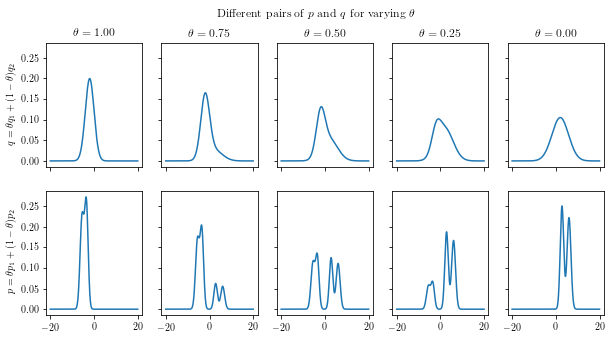

In [46]:
q_1 = lambda x: norm(loc=-2., scale=2.).pdf(x)
q_2 = lambda x: norm(loc=2., scale=3.8).pdf(x)

p_1 = lambda x: (norm(loc=-5.5, scale=.9).pdf(x) + norm(loc=-3.5, scale=.8).pdf(x)) / 2.
p_2 = lambda x: (norm(loc=2.8, scale=.8).pdf(x) + norm(loc=6., scale=.9).pdf(x)) / 2.
#p_2 = p_1

# Show the resulting distributions for different theta
steps = 5
f, axs = plt.subplots(2,steps, sharex=True, sharey=True, figsize=(10,5))
for ax0, ax1, theta in zip(axs[0], axs[1], np.linspace(1,0,steps)):
    ax0.plot(x, theta * q_1(x) + (1 - theta) * q_2(x))
    ax1.plot(x, theta * p_1(x) + (1 - theta) * p_2(x))
    ax0.set_title(r'$\theta = %.2f$' %(theta))
axs[1][0].set_ylabel(r'$p=\theta p_1 + (1-\theta) p_2$')
axs[0][0].set_ylabel(r'$q=\theta q_1 + (1-\theta) q_2$')
plt.suptitle(r"Different pairs of $p$ and $q$ for varying $\theta$")
plt.show()

### Defining a Convex Set

In this section, we define a convex set by defining $\hat{q} = \mathcal{N}(\theta \mu_1 + (1-\theta) \mu_2)$.
Now, $\hat{q} \in \mathcal{S}$ and we can test for convexity. 
Next, we define the functions for general check of convexity in the pairs of $\mu$.

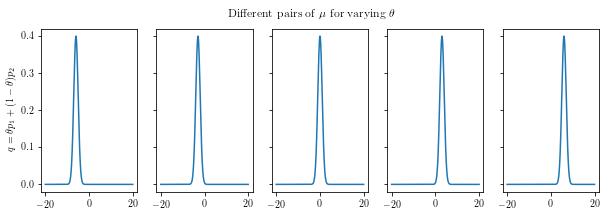

In [47]:
# the true distribution
p = lambda x: (norm(loc=-4., scale=.8).pdf(x) + norm(loc=4., scale=.9).pdf(x)) / 2.
# The proxies for testing on convexity
q = lambda x, theta: norm(loc=theta * -6 + (1 - theta) * 6., scale=1.).pdf(x)
q_theta_0 = lambda x: q(x, 0.)
q_theta_1 = lambda x: q(x, 1.)

# Show the resulting distributions for different theta
steps = 5
f, axs = plt.subplots(1,steps, sharex=True, sharey=True, figsize=(10,3))
for ax, theta in zip(axs, np.linspace(1,0,steps)):
    ax.plot(x, q(x, theta))
    ax0.set_title(r'$\theta = %.2f$' %(theta))
axs[0].set_ylabel(r'$q=\theta p_1 + (1-\theta) p_2$')
#axs[0][0].set_ylabel(r'$q(\theta \mu_1 + (1-\theta) \mu_2)$')
plt.suptitle(r"Different pairs of $\mu$ for varying $\theta$")
plt.show()

### Plot the Functions

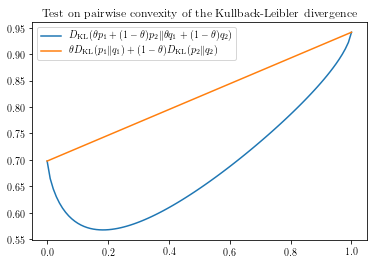

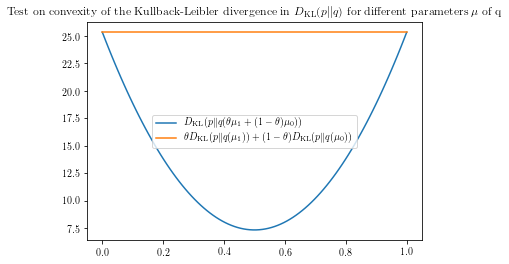

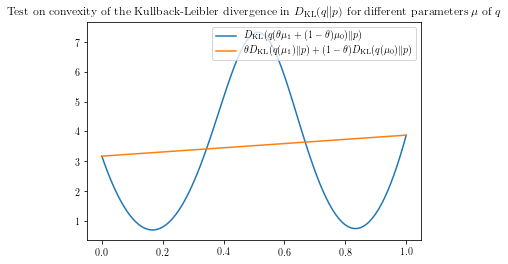

In [48]:
# pairwise DKL
dkl_1 = []
dkl_2 = []
# DKL(q||p)
dkl_qp_1 = []
dkl_qp_2 = []
# DKL(p||q)
dkl_pq_1 = []
dkl_pq_2 = []


Theta = np.linspace(1,0,100)
for theta in Theta:
    dkl_1.append(entropy(qk=theta * q_1(x) + (1 - theta) * q_2(x),
                         pk=theta * p_1(x) + (1 - theta) * p_2(x)))
    dkl_2.append(theta * entropy(qk=q_1(x), pk=p_1(x)) +
                 (1 - theta) * entropy(qk=q_2(x), pk=p_2(x)))

    #dkl.append(entropy(qk=q_tmp(x), pk=p_tmp(x)))
    dkl_qp_1.append(entropy(qk=p(x), pk=q(x, theta)))
    dkl_qp_2.append(theta * entropy(qk=p(x), pk=q_theta_1(x)) + (1-theta) * entropy(qk=p(x), pk=q_theta_0(x)))

    dkl_pq_1.append(entropy(pk=p(x), qk=q(x, theta)))
    dkl_pq_2.append(theta * entropy(pk=p(x), qk=q_theta_1(x)) + (1-theta) * entropy(pk=p(x), qk=q_theta_0(x)))

# # DKL(p||q) in the pair (p_1, q_1) and (p_2, q_2)
plt.plot(Theta, dkl_1, label=r"$D_{\text{KL}} ( \theta p_1 + (1-\theta ) p_2 \| \theta q_1 + (1-\theta ) q_2 ) $")
plt.plot(Theta, dkl_2, label=r"$\theta D_{\text{KL}}(p_1 \| q_1 ) + (1 - \theta) D_{\text{KL}}(p_2 \| q_2 ) $")
plt.legend()
plt.title(r"Test on pairwise convexity of the Kullback-Leibler divergence")
plt.show()

# DKL(p||q)  in the pair mu_1 and mu_2 of q
plt.plot(Theta, dkl_pq_1, label=r"$D_{\text{KL}} (p \| q(\theta \mu_1 + (1-\theta) \mu_0 ))$")
plt.plot(Theta, dkl_pq_2, label=r"$\theta D_{\text{KL}} (p \| q( \mu_1 )) + (1-\theta) D_{\text{KL}} (p \| q(\mu_0 ) )$")
plt.title(r"Test on convexity of the Kullback-Leibler divergence in $D_{\text{KL}} (p \| q)$ for different parameters $\mu$ of q")
plt.legend()
plt.show()

# DKL(q||p) in the pair mu_1 and mu_2 of q
plt.plot(Theta, dkl_qp_1, label=r"$D_{\text{KL}} (q(\theta \mu_1 + (1-\theta) \mu_0 ) \| p)$")
plt.plot(Theta, dkl_qp_2, label=r"$\theta D_{\text{KL}} (q( \mu_1 ) \| p) + (1-\theta) D_{\text{KL}} (q(\mu_0 ) \| p)$")
plt.title(r"Test on convexity of the Kullback-Leibler divergence in $D_{\text{KL}} (q \| p)$ for different parameters $\mu$ of $q$")
plt.legend()
plt.show()


We see from the upper plot, that the [convexity proof](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence#Properties)
on pairs of distributions hold for the depicted parameters.
In some last section, we stated that the direction $D_{\text{KL}}(p\|q)$ is convex, which is also shown in the middle plotted for one example.

The remaining questions is, if $D_{\text{KL}}(q\|p)$ is convex.
In the lower plot we depicted $D_{\text{KL}}(q\|p)$ for one example, which shows __non-convex__ behaviour.
Therefore, we cannot say in general when and for what $p$ the objective $D_{\text{KL}}(q\|p)$ becomes convex.
However, it is generally known that $D_{\text{KL}}(q\|p)$ is convex when all modes of $p$ lie very close together (c.f. [Deep Learning by Bengio on page 71](https://www.deeplearningbook.org/contents/prob.html)).  



# Appendix

## Sets

### Convex Set

A set $S$ is convex iff for every pair of points $x,y\in S$, the line segment $\overline{xy}$ joining $x$ to $y$ is a subset of $S$.
$S$ is convex iff it contains every convex combination of its points.
Convex combinations are the special case of affine combinations in which all of the coefficients are non-negative.
That is, a convex combination of the points $x_1,\dots,x_n\in S$ is any point of the form

$$a_1x_1+a_2x_2+\cdots+a_nx_n$$

such that

$$a_1+a_2+\cdots+a_n=1$$

**and**

$$a_1,a_2,\dots,a_n\ge 0\;.$$

In literatur, a convex set $\mathcal{S}$ is often simply build by choosing some $s_1$ and $s_2$ and then defining
$\mathcal{S}:=\left \{ s\mid \theta s_1 + (1 - \theta) s_2, s_1 \in \mathbb{R}, s_2 \in \mathbb{R}, \theta \in \left[ 0, 1\right] \right \}$.
The set $\mathcal{S}$ describes a line for which every point of the convexity test lies on the line.
(Test for convexity: For any $\hat{s}_1, \hat{s}_2 \in \mathcal{S}$ the point
 $s = \theta \, \hat{s}_1 + (1-\theta) \hat{s}_2$ is in
 $\mathcal{S}$ ($\Rightarrow s\in\mathcal{S} \Leftrightarrow \mathcal{S} \text{ is convex}$))

### Affine Set

$S$ is affine iff for every pair of points $x,y\in S$, the whole infinite line containing $x$ and $y$ is a subset of $A$.
$S$ is affine iff it contains every affine combination of its points, where an affine combination of the points $x_1,\dots,x_n\in S$ is any point of the form

$$a_1x_1+a_2x_2+\cdots+a_nx_n$$

such that

$$a_1+a_2+\cdots+a_n=1\;.$$

**Example**: In the xy-plane $S=\{(x,0):0\le x\le 1\}$ is a convex set but not an affine set:
the smallest affine set containing $S$ is the whole $x$-axis.

### Convex Set vs Affine Set

A convex combination of points is a kind of 'weighted average' of those points.
An affine combination is a 'weighted average' in which some of the weights are allowed to be negative.
Thus, convexity is a special case of affinity:
**A set is affine $\Rightarrow$ a set is convex, but not vice versa.**

## Convex and Concave Functions

Let $X$ be a convex set $f: X \rightarrow \mathbb{R}$ be a function.

* $f$ is called __convex__ if:

$$\forall x_1, x_2 \in X, \forall \theta \in [0, 1]: \qquad f(\theta x_1+(1-\theta )x_2)\leq \theta f(x_1)+(1-\theta)f(x_2)$$

* $f$ is called **strictly convex** if:

$$\forall x_1 \neq x_2 \in X, \forall \theta \in (0, 1): \qquad f(\theta x_1+(1-\theta)x_2) < \theta f(x_1)+(1-\theta)f(x_2)$$

* A function $f$ is said to be (strictly) concave if $-f$ is (strictly) convex.

## Note on Convex optimization

A convex optimization problem is an __optimization problem__ in which the objective function is a __convex function__ (e.g. $f(x)=x^2$)
 and the feasible set (aka feasible region, feasible set, search space, solution space, support)
__is a convex set__ (e.g. $\mathcal{X}:=\left\{ x | x \in \mathbb{R}^+ \right\}$). A function $f$  mapping some subset of $\mathbb{R}^n$ into $\mathbb{R} \cup \{\pm \infty\}$ is convex
if its domain is convex and for all $\theta \in [0, 1]$ and all $x, y$ in its domain, the following condition holds: $f(\theta x + (1 - \theta)y) \leq \theta f(x) + (1 - \theta) f(y)$.
A set S is convex if for all members $x, y \in S$ and all $\theta \in [0, 1]$, we have that $\theta x + (1 - \theta) y \in S$.


## Further Readings

### Set

* Convexity and Affineness: https://math.stackexchange.com/a/88753/748434
* Convex Optimization and definitions (e.g. chapter 2.1.4 from Boyd & Vandenberghe): https://web.stanford.edu/~boyd/cvxbook/bv_cvxbook.pdf
* Is the set of probability density functions convex?: https://math.stackexchange.com/a/1794708/748434

### KL Divergence, Exponential Families and their Convexity

* A digest of exponential families (Taxonomy, Flashcards, etc.): https://arxiv.org/pdf/0911.4863.pdf
* Exponential Families (Blei): https://www.cs.princeton.edu/courses/archive/fall11/cos597C/lectures/exponential-families.pdf
* Notes on Convexity of Loss Functions for Classification (nice visualization): https://drscotthawley.github.io/Notes-On-Convexity/
* Minimising the Kullback–Leibler Divergence (eq. 2.3 & 2.4 give an example in eq. 2.3 and 2.4, if $q$ is Gaussian): http://www.herbrich.me/papers/KL.pdf
* The exponential family (Sufficiency, maximum likelihood estimates, and KL Divergence): https://www.ntu.edu.sg/home/lixiucheng/books/exponential-family.html
* ENTROPIES AND CROSS-ENTROPIES OF EXPONENTIAL FAMILIES (BREGMAN DIVERGENCES AND RELATIVE ENTROPY OF EXPONENTIAL FAMILIES): https://www.lix.polytechnique.fr/~nielsen/EntropyEF-ICIP2010.pdf
* Exponential Families - Canonical Parametrization (good definition on MLE, Bregman Divergences and KL Divergences, and convexity): http://www.stat.cmu.edu/~siva/705/lec13.pdf
* The Exponential Family and Statistical Applications: https://www.stat.purdue.edu/~dasgupta/expfamily.pdf
* What is the rationale behind the exponential family of distributions?: https://stats.stackexchange.com/questions/326830/what-is-the-rationale-behind-the-exponential-family-of-distributions
* sufficient statistic and KL-divergence - Confusion with an equation (nicely written KL divergence for q is exponential): https://stats.stackexchange.com/questions/99838/sufficient-statistic-and-kl-divergence-confusion-with-an-equation
* Maximum Likelihood in Exponential Families (log-likelihood function is strictly concave): http://www.stats.ox.ac.uk/~steffen/teaching/bs2siMT04/si6bw.pdf
* Exponential Family (Maximum Likelihood Estimationis concave): https://people.eecs.berkeley.edu/~jordan/courses/281A-fall04/lectures/lec-10-5.pdf
* Information Theory in Computer Science (Properties of Mutual Information - Concavity and Convexity): https://homes.cs.washington.edu/~anuprao/pubs/CSE533Autumn2010/lecture3.pdf
* About some properties of the Kullback-Leibler divergence: https://camo.ici.ro/journal/vol11/v11d15.pdf
* Renyi Divergence and Kullback-Leibler Divergence: https://arxiv.org/pdf/1206.2459.pdf

### Convex Optimization

* Convex optimization and SVMs: http://www2.stat.duke.edu/~sayan/863/lec/optim.pdf
* Subspaces, Affine sets, Convex sets, Cones: http://homepages.rpi.edu/~mitchj/handouts/affine/

### Other Stuff

* Minimizing the sum of KL divergences: https://math.stackexchange.com/questions/3024947/minimizing-the-sum-of-kl-divergences
* Stochastic Gradient Descent: https://www.cs.princeton.edu/courses/archive/fall13/cos521/lecnotes/lec19.pdf
* Optimization perspective on approximate Bayesian inference (Walk through Bishops book): http://niaohe.ise.illinois.edu/IE598_2016/pdf/IE598_Presentation10_Juho_Kim.pdf